# Load

In [ ]:
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from anndata import AnnData
from scipy.sparse import diags
from scipy.io import mmwrite
from scipy import sparse
from scipy.optimize import fsolve,minimize
from tqdm import tqdm
from pathlib import Path
from typing import Union, Optional
import pickle
import seaborn as sns

In [ ]:
from scDenorm.denorm import *

In [ ]:
from scAnnot.tools import *

In [ ]:
import matplotlib as mpl
sc.set_figure_params(scanpy=True, fontsize=14,facecolor=None,frameon=False,transparent=True)
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.grid'] = False

## PBMC

In [ ]:
ad=sc.read('data/pbmc3k_raw.h5ad')

In [ ]:
ad

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [ ]:
scaled_counts0=ad.copy().X.tocsr().asfptype()
sc.pp.normalize_total(ad, target_sum=1e4)
scaled_counts1=ad.copy().X.tocsr().asfptype()
sc.pp.log1p(ad)
smtx = ad.X.tocsr().asfptype()
scaled_counts2=ad.copy().X.tocsr().asfptype()

### plot the scaled data

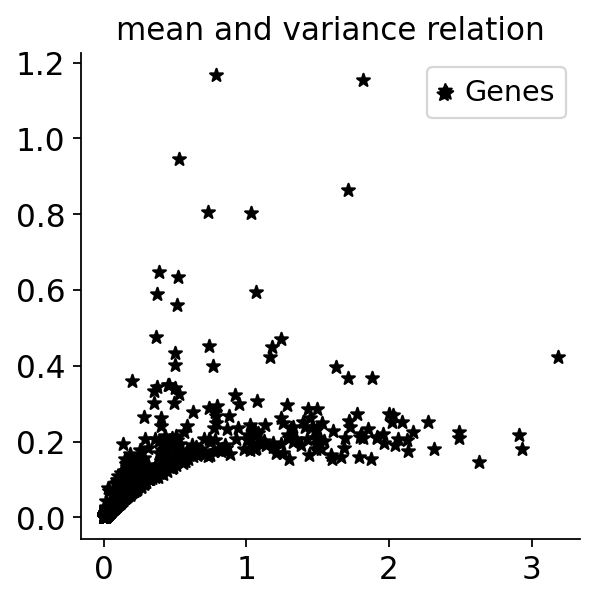

In [ ]:
cmean = np.array(smtx.mean(0))
cvar = np.array(smtx.power(2).mean(0) - cmean ** 2)

# plt.loglog()
plt.scatter(cmean, cvar, marker='*', c='k', label='Genes')
plt.legend(scatterpoints=3)
plt.title('mean and variance relation');
# plt.loglog;

If the points are roughly of the shape of a logarithm graph, i.e. concave up and lying below the diagonal line, then we can assume that it has been log transformed. If the data has been log transformed, we next determine the base of the logarithm; otherwise, skip to scaling factors. If the points are not distributed evenly, try a log-scaled plot.

In [ ]:
scaled_counts=smtx

In [ ]:
scaled_counts0.data

array([1., 1., 2., ..., 1., 1., 3.], dtype=float32)

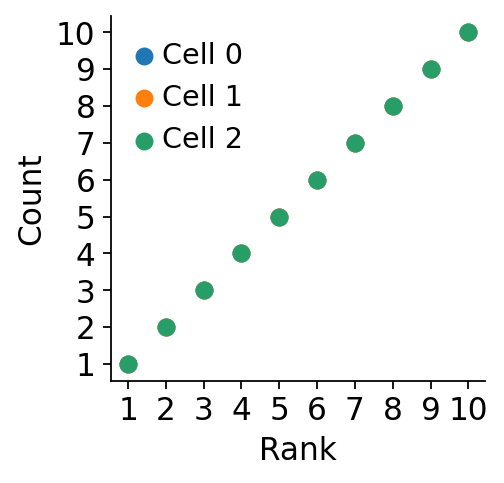

In [ ]:
figsize(3,3)
fig, ax = plt.subplots()
for c_idx in [0,1,2]:
    N = 10
    c = pd.Series(scaled_counts0.getrow(c_idx).data)
    y = np.array(c.value_counts().sort_index().head(N).index)
    x = np.arange(1, N+1)
    ax.scatter(x[::-1], y[::-1], label=f'Cell {c_idx}',s=50, marker='o');
    
ax.set_xlabel('Rank')
ax.set_ylabel('Count')
plt.legend(frameon=False)
plt.xticks(x);
plt.yticks(y);
plt.savefig('figures/count.pdf',dpi=300, bbox_inches='tight',transparent=True)

In [ ]:
c.value_counts().sort_index().head(10)

1.0     556
2.0      77
3.0      22
4.0      17
5.0      24
6.0       6
7.0       6
8.0       6
9.0       1
10.0     10
dtype: int64

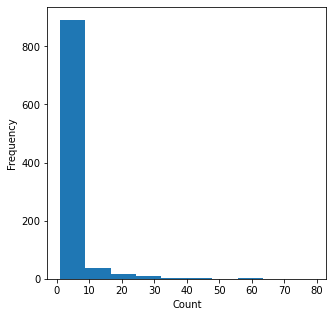

In [ ]:
plt.hist(c)
plt.xlabel('Count')
plt.ylabel('Frequency');

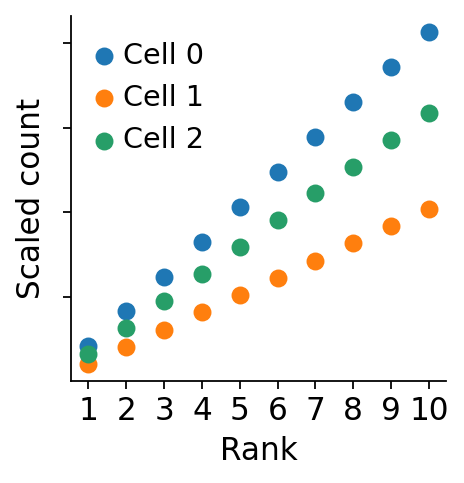

In [ ]:
figsize(3,3)
fig, ax = plt.subplots()
for c_idx in [0,1,2]:
    N = 10
    c = pd.Series(scaled_counts1.getrow(c_idx).data)
    y = np.array(c.value_counts().sort_index().head(N).index)
    x = np.arange(1, N+1)
    ax.scatter(x[::-1], y[::-1], label=f'Cell {c_idx}',s=50, marker='o');
    
ax.set_xlabel('Rank')
ax.set_ylabel('Scaled count')
ax.set_yticklabels([])
plt.legend(frameon=False)
plt.xticks(x);
plt.savefig('figures/scaled.pdf',dpi=300, bbox_inches='tight',transparent=True)

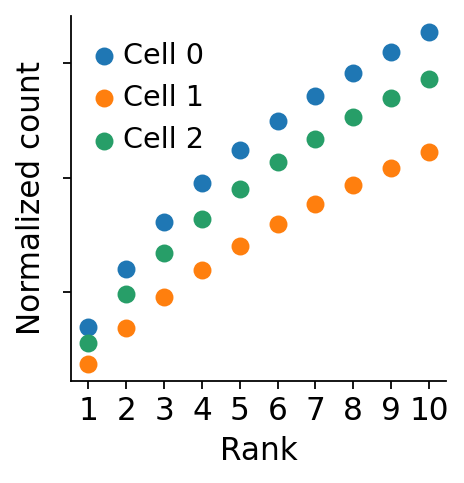

In [ ]:
figsize(3,3)
fig, ax = plt.subplots()
for c_idx in [0,1,2]:
    N = 10
    c = pd.Series(scaled_counts2.getrow(c_idx).data)
    y = np.array(c.value_counts().sort_index().head(N).index)
    x = np.arange(1, N+1)
    ax.scatter(x[::-1], y[::-1], label=f'Cell {c_idx}',s=50, marker='o');
    
ax.set_xlabel('Rank')
ax.set_ylabel('Normalized count')
ax.set_yticklabels([])
plt.legend(frameon=False)
plt.xticks(x);
plt.savefig('figures/norm.pdf',dpi=300, bbox_inches='tight',transparent=True)

# Time Top-2 rank vs Regression

In [ ]:
import timeit

In [ ]:
ress=[]
for c_idx in range(1000):
    N = 10
    c = pd.Series(scaled_counts1.getrow(c_idx).data)
    y = np.array(c.value_counts().sort_index().head(N).index)
    x = np.arange(1, y.shape[0]+1)
    
    start_time = timeit.default_timer()
    np.abs(y[0]-y[1]/2)<1e-5
    ress.append(['Top-2 rank equation',timeit.default_timer() - start_time])
    
    start_time = timeit.default_timer()
    res = minimize(solve_s,[1], method='L-BFGS-B', tol=1e-5,args=(x,y))
    ress.append(['Regression-based',timeit.default_timer() - start_time])

In [ ]:
tmp=pd.DataFrame(ress,columns=['Methods','Time'])

In [ ]:
tmp

,Methods,Time
0,Top-2 rank equation,0.000020
1,Regression-based,0.001819
2,Top-2 rank equation,0.000013
3,Regression-based,0.001015
4,Top-2 rank equation,0.000012
...,...,...
1995,Regression-based,0.000534
1996,Top-2 rank equation,0.000012
1997,Regression-based,0.000536
1998,Top-2 rank equation,0.000005


(array([0, 1]),
 [Text(0, 0, 'Top-2 rank equation'), Text(1, 0, 'Regression-based')])

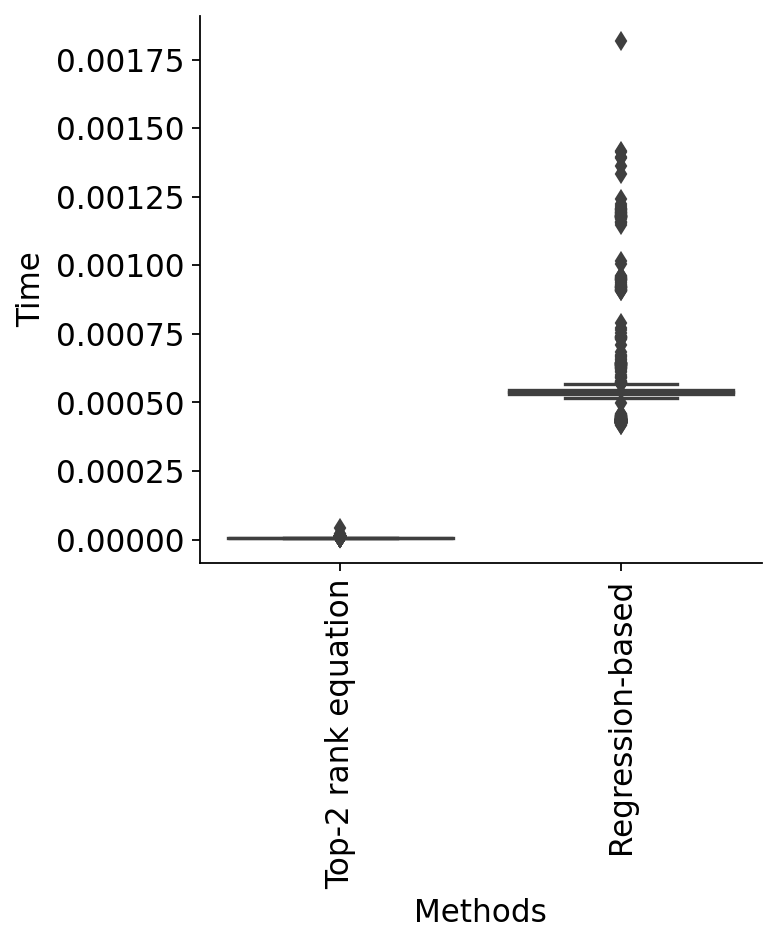

In [ ]:
figsize(4.5,4.5)
sns.boxplot(x='Methods', y='Time', data=tmp)
plt.xticks(rotation=90)

# Robustness

In [ ]:
def solve_s(s,C,X):
    return sum((C*s-X)**2)

In [ ]:
res = minimize(solve_s,[1], method='L-BFGS-B', tol=1e-5,args=(x,y))

In [ ]:
ress=[]
for c_idx in range(1000):
    N = 10
    c = pd.Series(scaled_counts1.getrow(c_idx).data)
    y = np.array(c.value_counts().sort_index().head(N).index)
    x = np.arange(1, y.shape[0]+1)
    res = minimize(solve_s,[1], method='L-BFGS-B', tol=1e-5,args=(x,y))
    ress.append([res.fun,res.x[0],y[0],res.fun<1e-5,np.abs(y[0]-y[1]/2)<1e-5])

In [ ]:
ress=pd.DataFrame(ress,columns=['loss','st','s0','regression','equation'])

In [ ]:
tmp=pd.DataFrame([['Top-2 rank equation',ress.equation.sum()/ress.shape[0]],['Regression-based',ress.regression.sum()/ress.shape[0]]],columns=['Methods','Percentage'])

In [ ]:
tmp

,Methods,Percentage
0,Top-2 rank equation,1.000
1,Regression-based,0.955


(array([0, 1]),
 [Text(0, 0, 'Top-2 rank equation'), Text(1, 0, 'Regression-based')])

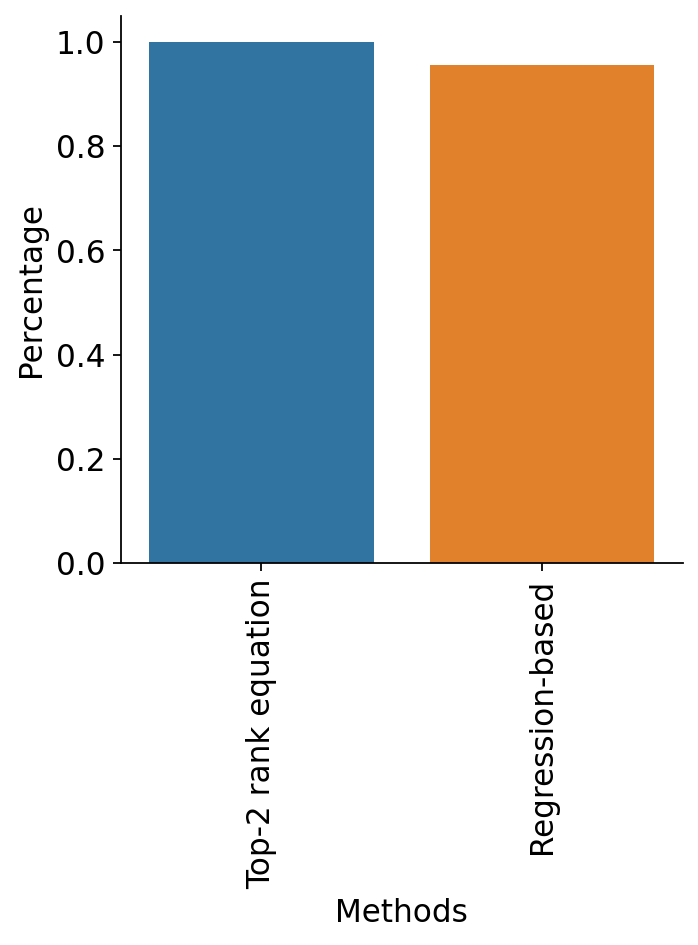

In [ ]:
figsize(4.5,4.5)
sns.barplot(x='Methods', y='Percentage', data=tmp)
plt.xticks(rotation=90)

# 

In [ ]:
tmp=sc.read('/home/huang_ziliang/project/brain/data/public/human_brain_CNS_Marsh_2022_10x/h5/human_brain_CNS_Marsh_2022_10x.h5ad')

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
tmp

AnnData object with n_obs × n_vars = 139071 × 68308
    obs: 'sample', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    layers: 'counts'

In [ ]:
ress=[]
numpy.random.seed(0)
for i in range(10):
    n=(i+1)*1000
    for _ in range(10):
        ad=tmp[numpy.random.choice(np.arange(tmp.shape[0]),n,replace=False),numpy.random.choice(np.arange(tmp.shape[1]),n,replace=False)].copy()
        sc.pp.normalize_total(ad, target_sum=1e4)
        sc.pp.log1p(ad)
        start_time = timeit.default_timer()
        new_ad=scdenorm(ad)
        ress.append(timeit.default_timer()-start_time)

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
100%|██████████| 10000/10000 [00:03<00:00, 3202.26it/s]


In [ ]:
tmp=pd.DataFrame([[(i+1)*1000 for i in range(10) for _ in range(10)],ress]).T

In [ ]:
tmp.columns=['GxC','Time']

Text(0, 0.5, 'Time')

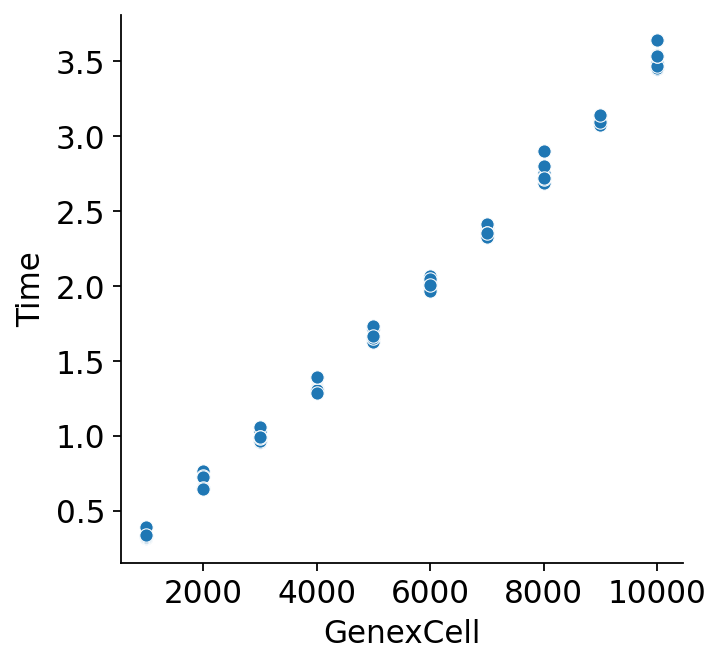

In [ ]:
sns.scatterplot(x='GxC',y='Time',data=tmp)
plt.xlabel('GenexCell')
plt.ylabel('Time')